<a href="https://colab.research.google.com/github/vibhavpan/BackTesting/blob/main/Back_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install yfinance pandas numpy matplotlib


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [26]:
#download historical data
def fetch_data(ticker,start_date,end_date):
  '''
  Fetch historical stock data from Yahoo finance
  '''
  data=yf.download(ticker,start=start_date,end=end_date)
  return data

data=fetch_data('SPY','2010-01-01','2020-12-31')
print('Data head: ')
print(data.head())

/tmp/ipython-input-26-2638824292.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed

Data head: 
Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.515656  85.560928  84.142335  84.791267  118944600
2010-01-05  85.742012  85.779743  85.153447  85.462824  111579900
2010-01-06  85.802353  86.013632  85.591074  85.658982  116074400
2010-01-07  86.164604  86.270244  85.402485  85.643948  131091100
2010-01-08  86.451302  86.489032  85.764644  85.938192  126402800


In [33]:
#Implmenet trading strategy

def moving_average_strategy(data,short_window=50,long_window=200):
  '''
  Simple Moving Average Crossover Stragey:
    -Buy when short MA crosses above long MA
    -Sell when short MA crosses below long MA

    Return:
      DataFrame with signals and positions
  '''
  df=data.copy()

  #calculate moving averages
  df['short_ma']=df['Close'].rolling(window=short_window).mean()
  df['long_ma']=df['Close'].rolling(window=long_window).mean()

  #Generate signals (1=buy,-1=sell,0=hold)
  df['signal']=0
  df.loc[df['short_ma']>df['long_ma'],'signal']=1
  df.loc[df['short_ma']<df['long_ma'],'signal']=-1

  #forward fill positions to hold until next signal
  df['position']=df['signal'].diff()

  #Remove NaN values created by using averages
  df=df.dropna()

  return df

strategy_df=moving_average_strategy(data)
print(strategy_df)
#print('\nStrategy Signals:')
#print(strategy_df[['Close','short_ma','long_ma','signal','position']])


Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2010-10-18   90.526726   90.825216   89.784326   90.113431  141204800   
2010-10-19   89.340446   90.197646   88.797036   89.692511  280604700   
2010-10-20   90.212959   90.649214   89.447600   89.501174  200051800   
2010-10-21   90.411957   91.146702   89.707827   90.618607  221585500   
2010-10-22   90.580322   90.718087   90.312448   90.549707  108212400   
...                ...         ...         ...         ...        ...   
2020-12-23  345.085876  347.010467  344.757280  345.752438   46201400   
2020-12-24  346.428345  346.456508  344.973169  345.564608   26457900   
2020-12-28  349.404449  349.798742  348.371731  349.000731   39000400   
2020-12-29  348.737915  351.122552  348.146447  350.944172   53680500   
2020-12-30  349.235535  350.277651  348.841242  349

In [39]:
#Backtest performance
def backtest_strategy(df,initial_capital=10000):
  '''
    Backtest the strategy:
      - calculate daily returns
      - simulate trades based on signal
      - track portfolio value
  '''
  backtest_df=df.copy()

  #calculate daily returns
  #.pct_change() Computes the fractional change from the immediately previous row by default.
  backtest_df['daily_return']=backtest_df['Close'].pct_change()

  #calculate strategy returns (shift returns by 1 day to avoid look-ahead bias)
  backtest_df['strategy_return']=backtest_df['daily_return']*backtest_df['signal'].shift(1)

  #calculate cummulative returns
  #cumprod returns dataframe with cummulative product
  backtest_df['cumulative_market']=(1+backtest_df['daily_return']).cumprod()
  backtest_df['cumulative_strategy']=(1+backtest_df['strategy_return']).cumprod()

  #calculate portfolio value
  backtest_df['portfolio_value']=initial_capital*backtest_df['cumulative_strategy']

  return backtest_df

backtest_results=backtest_strategy(strategy_df)
print('\n Backtest result summary:\n')
print(f"Final portfolio Value :${backtest_results['portfolio_value'].iloc[-1]:.2f}")
print(f"Total return strategy: {(backtest_results['cumulative_strategy'].iloc[-1]-1)*100:.2f}%")
print(f"Total return strategy: {(backtest_results['cumulative_market'].iloc[-1]-1)*100:.2f}%")


 Backtest result summary:

Final portfolio Value :$11728.02
Total return strategy: 17.28%
Total return strategy: 285.78%


(2569, 14)


<Figure size 1400x1000 with 0 Axes>

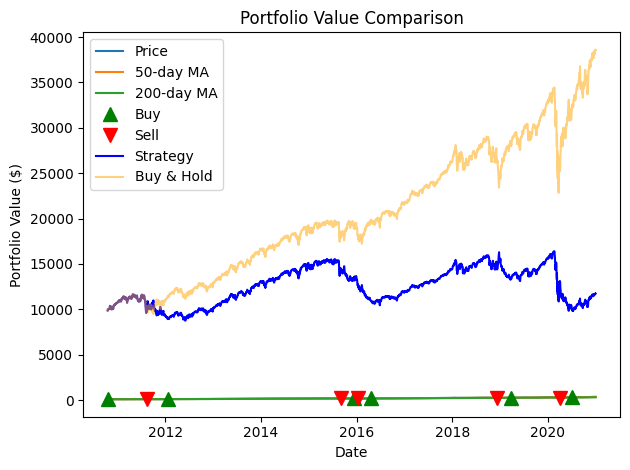

In [52]:
def plot_results(df):
  '''
  Plot backtesting results
  '''
  plt.figure(figsize=(14,10))

  plt.subplots(1,1)
  plt.plot(df['Close'],label='Price')
  plt.plot(df['short_ma'],label='50-day MA')
  plt.plot(df['long_ma'],label='200-day MA')

  #plot buy signals
  plt.plot(df[df['position']>0].index,
           df['short_ma'][df['position']>0],
           '^',markersize=10,color='g',label='Buy'
           )

  #plot sell signals
  plt.plot(df[df['position']<0].index,df['short_ma'][df['position']<0],
           'v',markersize=10,color='r',label='Sell')

  plt.title('Moving Average Crossover Strategy')
  plt.legend()
  plt.grid()

  plt.plot(df['portfolio_value'],label='Strategy',color='b')
  plt.plot(df['Close']/df['Close'].iloc[0]*10000, label='Buy & Hold',alpha=0.5,color='orange')
  plt.title('Portfolio Value Comparison')
  plt.xlabel('Date')
  plt.ylabel('Portfolio Value ($)')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

print(backtest_results.shape)
plot_results(backtest_results)

The annualized return, Sharpe ratio, volatility, and drawdown are all important metrics for evaluating investment performance. Annualized return represents the average yearly return of an investment over a specific period. The Sharpe ratio measures risk-adjusted return, indicating how much excess return is generated per unit of risk. Volatility, often measured by standard deviation, quantifies the fluctuation of returns. Drawdown, particularly maximum drawdown, represents the largest peak-to-trough decline in an investment's value.

In [54]:
def calculate_metrics(df):
  #calculate key performance metrics
  #Anualized return
  annualized_return=(df['cumulative_strategy'].iloc[-1]**(252/len(df))-1)*100

  #volatibilty
  volatibilty=df['strategy_return'].std()*np.sqrt(252)*100

  #sharpe ratio (assuming 0% risk free rate)
  sharpe=annualized_return/volatibilty

  #max drawdown
  cumulative_max=df['cumulative_strategy'].cummax()
  drawdown=(df['cumulative_strategy']-cumulative_max)/cumulative_max
  max_drawdown=drawdown.min()*100

  print('\nPerformace Metrics:\n')
  print(f'Annualized Return: {annualized_return:.2f}%')
  print(f'max draw down: {max_drawdown}')
  print(f'Sharped ration: {sharpe}')
  print(f'cummulative_max: {cumulative_max}')

calculate_metrics(backtest_results)


Performace Metrics:

Annualized Return: 1.58%
max draw down: -40.12370177640879
Sharped ration: 0.09201092960023718
cummulative_max: Date
2010-10-18         NaN
2010-10-19    0.986896
2010-10-20    0.996534
2010-10-21    0.998732
2010-10-22    1.000592
                ...   
2020-12-23    1.638631
2020-12-24    1.638631
2020-12-28    1.638631
2020-12-29    1.638631
2020-12-30    1.638631
Name: cumulative_strategy, Length: 2569, dtype: float64


In [40]:
'''!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install TA-Lib
'''

'!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz\n!tar -xvzf ta-lib-0.4.0-src.tar.gz\n%cd ta-lib\n!./configure --prefix=/usr\n!make\n!make install\n%cd ..\n!pip install TA-Lib\n'